In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
from pathlib import Path
import ecg_plot

from config import DATA_ROOT
from config_targets import TARGET_META

from utils import import_key_data
from ecg_predict import batched_predict_all
from eval import evaluate_all_payloads, evaluate_explanation
from explainer import run_fused_pipeline_for_classes
from selection import build_selection_df_with_aliases, build_y_true_from_labels

%load_ext autoreload
%autoreload 2

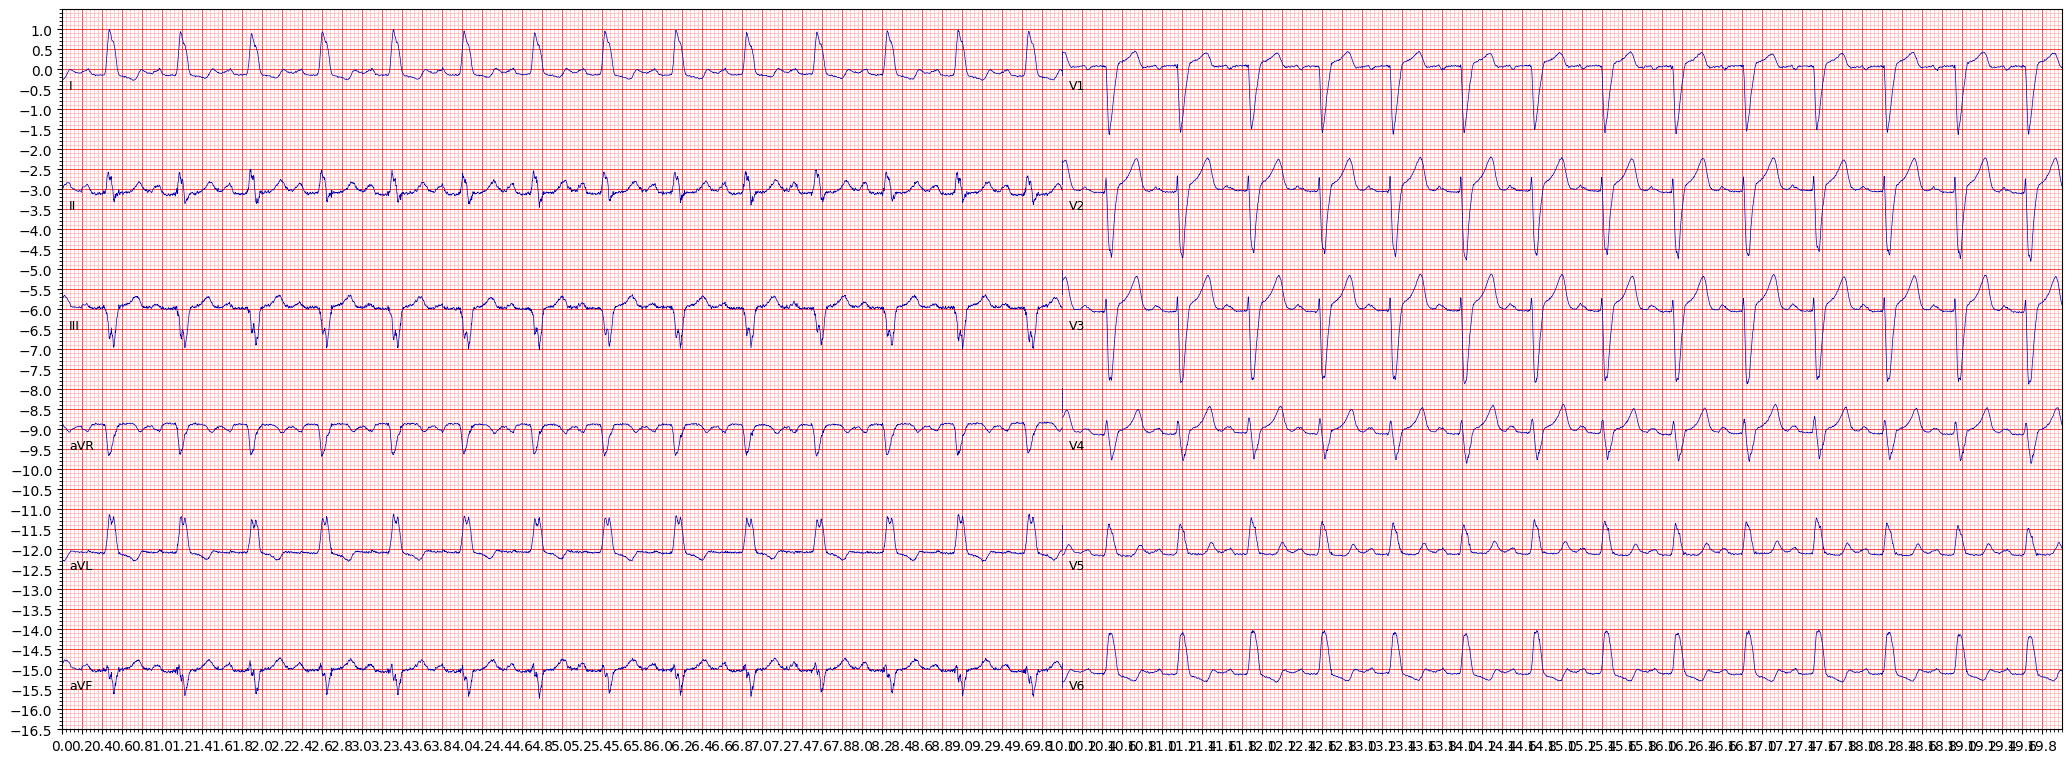

In [2]:
from utils import load_physionet_data

def plot_ecg(path):
    ecg_data = load_physionet_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()

plot_ecg("C:\data\georgia-12lead-ecg-challenge-database\Georgia\E10032.mat") 

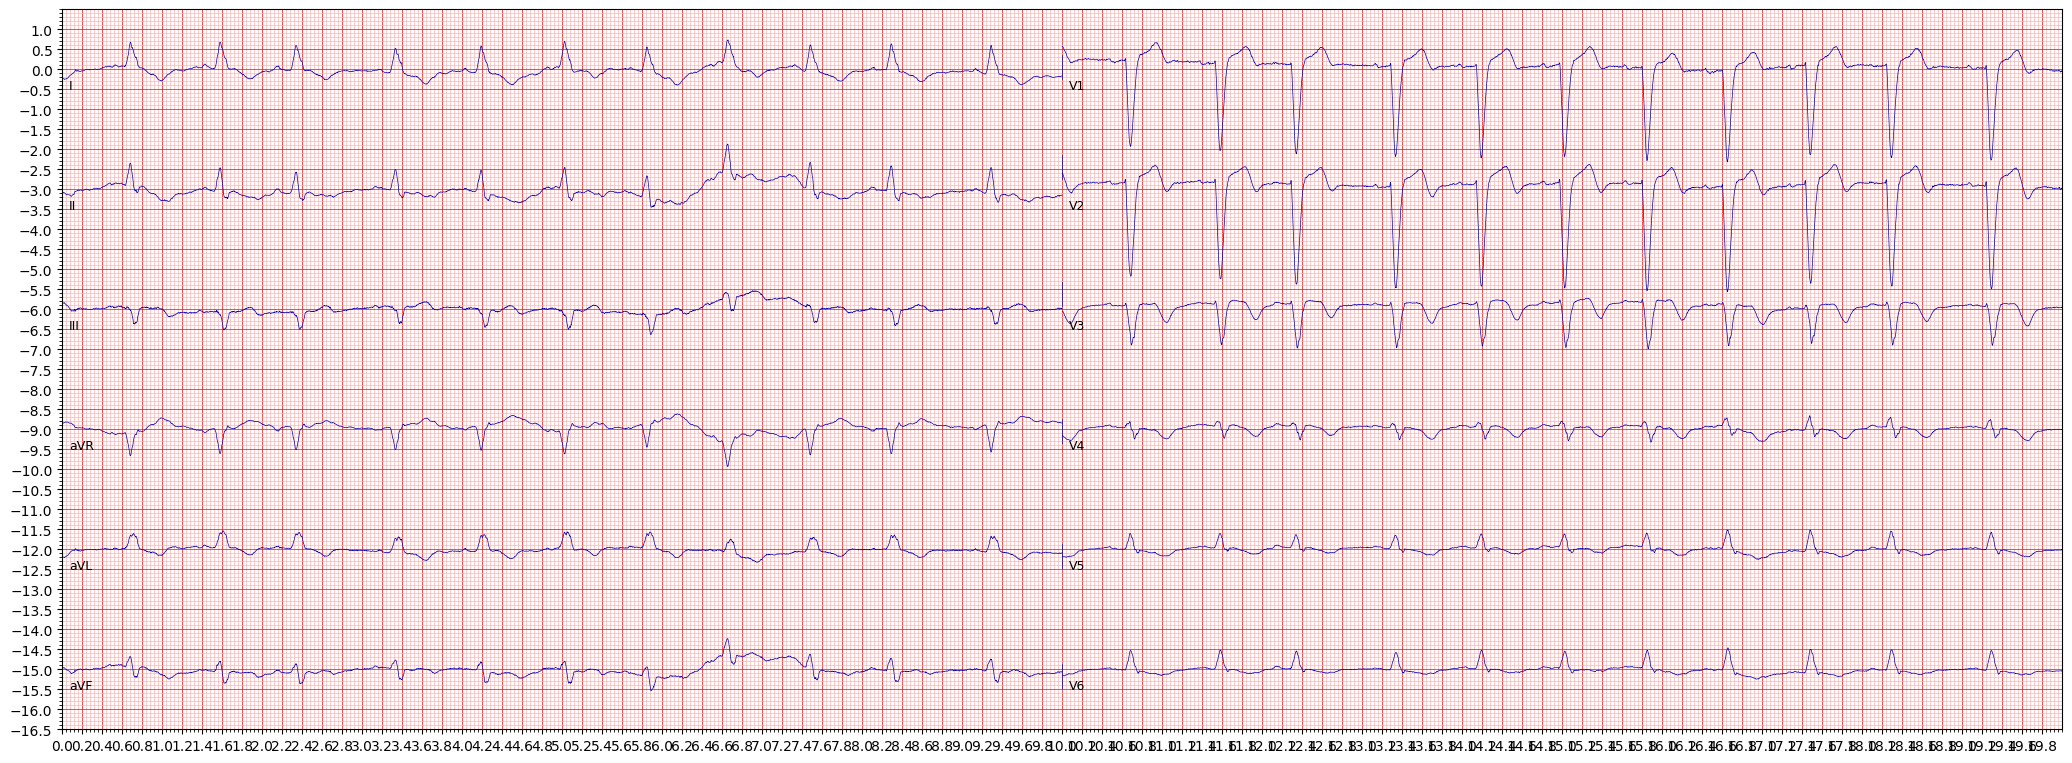

In [3]:
plot_ecg("C:\data\georgia-12lead-ecg-challenge-database\Georgia\E05581.mat")

<Figure size 2000x600 with 0 Axes>

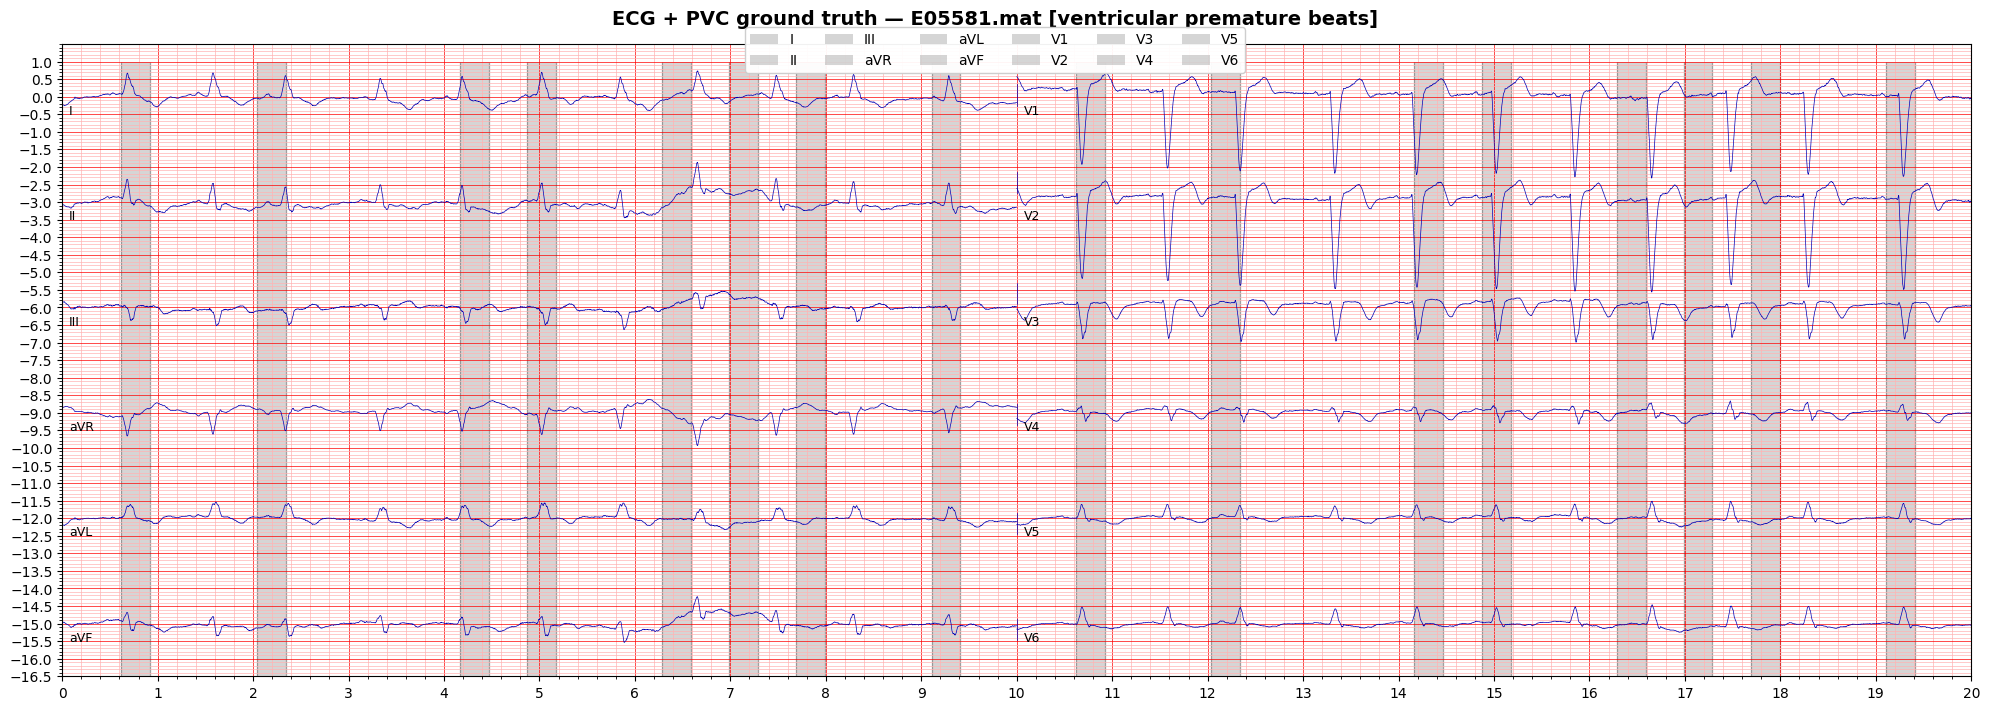

In [6]:
LIMB   = ["I","II","III","aVR","aVL","aVF"]
VLEADS = ["V1","V2","V3","V4","V5","V6"]
DEFAULT_LEADS = LIMB + VLEADS

from plot import plot_from_payload

# --- 1) PVC ground-truth times for E10032 (seconds) ---
pvc_times_e10032 = [0.77, 2.19, 4.316, 5.024, 6.438, 7.138, 7.842, 9.26]

# half-width of each shaded band around the R-peak (in seconds)
PVC_HALF_WIDTH = 0.15   # 300 ms window; tweak if you want narrower/wider bands

# path to your record
mat_path_e10032 = r"C:\data\georgia-12lead-ecg-challenge-database\Georgia\E05581.mat"

# --- 2) Build a payload that looks like a fused-explanation payload, but encodes GT bands ---
def build_pvc_groundtruth_payload(
    mat_path: str,
    pvc_times: list[float],
    page_seconds: float = 10.0,
    half_width: float = 0.15,
) -> dict:
    """
    Create a payload compatible with plot_from_payload, where perlead_spans
    encodes PVC ground-truth bands for *all 12 leads*.

    Each span is (start_sec, end_sec, weight), with times in seconds 0..page_seconds.
    """
    perlead_spans: dict[str, list[tuple[float, float, float]]] = {}

    for lead in DEFAULT_LEADS:   # I, II, III, aVR, aVL, aVF, V1–V6
        spans = []
        for t in pvc_times:
            s = max(0.0, t - half_width)
            e = min(page_seconds, t + half_width)
            spans.append((s, e, 1.0))  # weight=1.0 (uniform)
        perlead_spans[lead] = spans

    # simple lead_scores: number of bands per lead
    lead_scores = {lead: float(len(spans)) for lead, spans in perlead_spans.items()}

    payload = {
        "mat_path": mat_path,
        "target_label": "ventricular premature beats",
        "method_label": "PVC ground truth",
        "page_seconds": page_seconds,
        "perlead_spans": perlead_spans,
        "lead_scores": lead_scores,
        # you can omit top5_leads since we'll call show_all_leads=True
    }
    return payload


payload_gt_e10032 = build_pvc_groundtruth_payload(
    mat_path_e10032,
    pvc_times_e10032,
    page_seconds=10.0,
    half_width=PVC_HALF_WIDTH,
)

# --- 3) Plot: ECG + ground-truth PVC shading using your plot_from_payload ---
plot_from_payload(
    payload_gt_e10032,
    show_all_leads=True,        # <— important: shade all leads, not just top-5
    alpha_fill=0.35,            # tweak transparency if needed
    alpha_min=0.20,
    figsize=(20, 6),
)
